In [5]:
from scipy import signal
import pywt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LogNorm, NoNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import neurokit2 as nk

In [136]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt
    # Проведем детрендинг и нормализацию
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev
    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes) 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = freqs * fs
    
    return times, frequencies, coef

## Проверка вейвлет-преобразования на простом сигнале

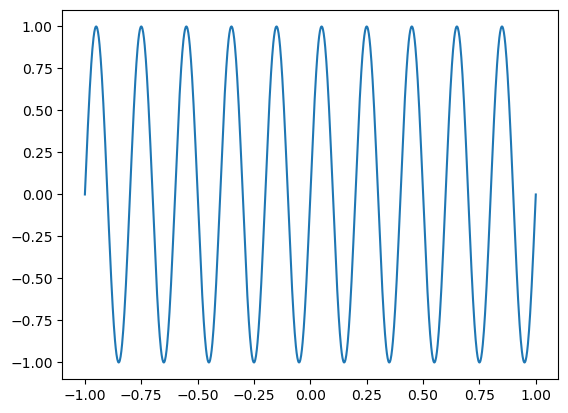

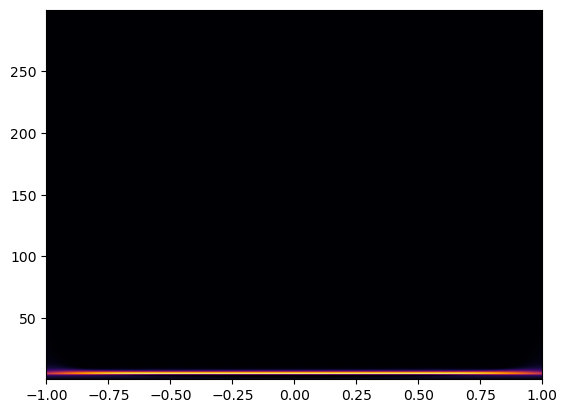

In [7]:
t, dt = np.linspace(-1, 1, 1200, retstep=True)
sig  = np.zeros(1200)

frequency = 2 * np.pi * 5
sig = np.sin(frequency * t) #+ np.sin(2 * frequency * t)

nNotes = 23
nOctaves = int(np.log2(2*np.floor(len(sig)/2.0)))
scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

cwtmatr, fre = pywt.cwt(sig, scales, 'cmor1.5-1.0')
frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt

plt.figure()
plt.plot(t, sig)
plt.show()

plt.figure()

plt.pcolormesh(t, frequencies, np.abs(cwtmatr), cmap='inferno', shading='gouraud')
plt.show()

## Работает

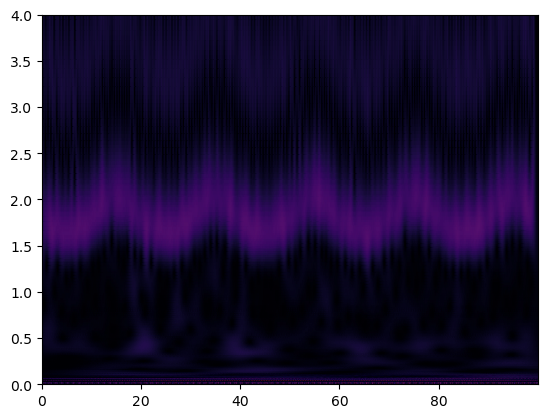

In [142]:
sampling_frequency = 100

ppg = nk.ppg_simulate(duration=100, sampling_rate=sampling_frequency, heart_rate=110)

times, frequencies, coif = cwt_spectrogram(ppg, sampling_frequency, nNotes=24)
plt.pcolormesh(times, frequencies, np.abs(coif), cmap='inferno', shading='gouraud')
plt.ylim([0, 4])
plt.show()


## Теперь посчитаем спектрограмму и пройдемся по алгоритму

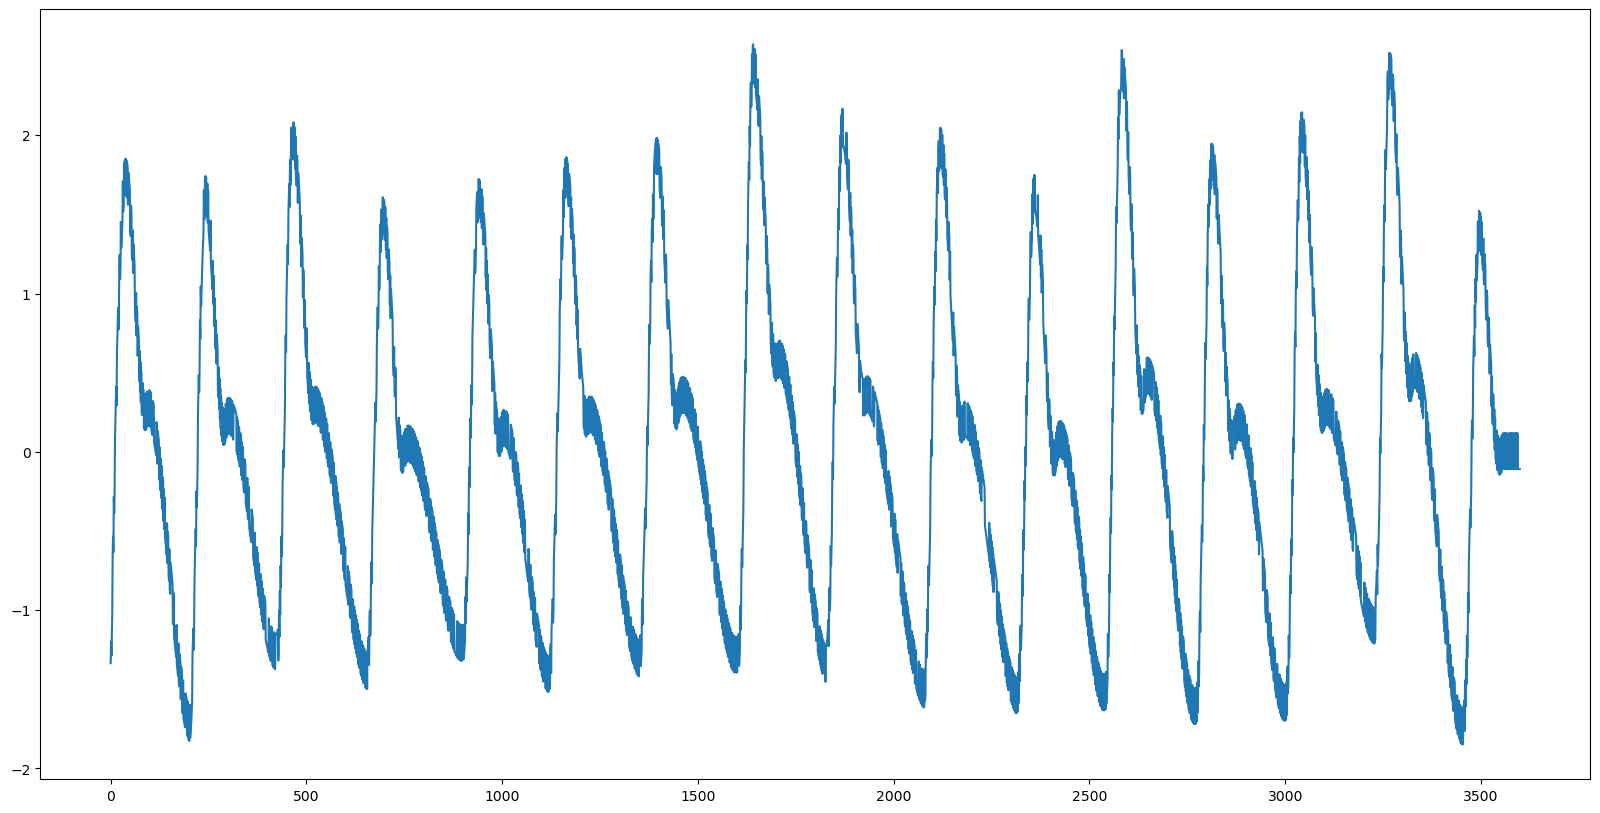

In [177]:
sampling_frequency = 360 #Hz
totalTime = 10 #seconds

ppg = nk.ppg_simulate(duration=10, sampling_rate=sampling_frequency, heart_rate=100)
ppg = ppg + np.ones(len(ppg)) * np.random.randint(-1, 1, len(ppg)) * 0.1

plt.figure(figsize=(20, 10))

x = signal.detrend(ppg,type='linear')
stddev = x.std()
x = x / stddev
x = x - x.mean()

plt.plot(x)

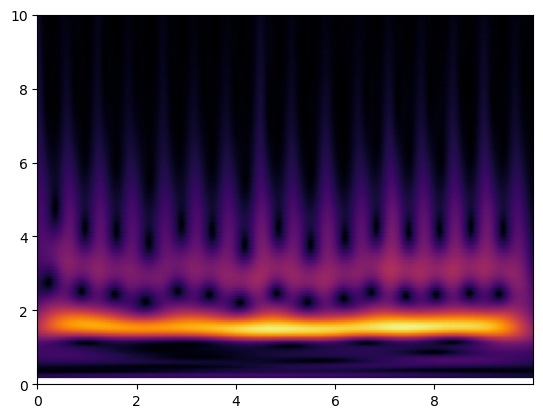

In [178]:

times, frequencies, coif = cwt_spectrogram(ppg, sampling_frequency, nNotes=24)

plt.pcolormesh(times, frequencies, np.abs(coif), cmap='inferno', shading='gouraud')
plt.ylim([0, 10])
plt.show()

In [19]:
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data

In [168]:
def cross_times(steps, n):
 
    current_level = 0
    previous_level = 0
    count = 0
    for i in range(1, n):
        previous_level = steps[i - 1]
        current_level = steps[i]
        # Update the previous level and
        # current level by value given
        #in the steps array
        if previous_level * current_level < 0:
            count += 1
 
    return count

In [13]:
def NmaxelementsFrequencies(list1, N):
    final_list = []
 
    for i in range(0, N):
        max1 = 0
        indices = 0
 
        for j in range(len(list1)):
            if list1[j] > max1:
                max1 = list1[j]
                indices = j
 
        list1 = np.delete(list1, np.where(list1 == max1))
        final_list.append(frequencies[indices])
 
    return np.asarray(final_list)

In [182]:
print("raw heart rate in bpm: ")
result_rate = []
signal_duration = len(ppg) / sampling_frequency
for i in range(coif.shape[1]):
    s =  np.abs(coif.T[i][:])
    t_start = 0.5 * i
    test_len = float(2.0)
    
    if (test_len + t_start > signal_duration):
        break 
    #print(test_len)
    x = ppg[int(t_start*sampling_frequency):int(t_start + test_len)*sampling_frequency]
    f_max = frequencies[np.argmax(s)]
    threshold = 0
    if f_max > 2:
        threshold = 2.5
    elif f_max < 1:
        threshold = 1.5
    else:
        threshold = 2
    filtered_x = bandpass(x, [0.1, threshold], sampling_frequency)
    n_zero_cross = cross_times(filtered_x, len(filtered_x))
    n_loc_max= len(signal.find_peaks(filtered_x)[0])
    upper_estimate = 1/test_len * n_loc_max
    lower_estimate = 1/test_len * 0.5 * n_zero_cross
    estimate = 0.5 * (lower_estimate + upper_estimate)
    F = NmaxelementsFrequencies(s, 3)
    f_hr = F[np.argmin(np.abs(F - estimate))]
    result_rate.append(f_hr * 60)

print(np.asarray(result_rate).mean())


raw heart rate in bpm: 
92.33781340338078
